# Building A neural network from scratch

In [179]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
def initialization(dims):    
    #firt initializations
    para = {}
    for i in range(1, len(dims)):
        para["W" + str(i)] = np.random.randn(dims[i], dims[i-1]) * 0.01
        para["b" + str(i)] = np.zeros((dims[i], 1))
    return para


def foward(X, para, layer_act, dims):
    comput = {}
    A_prev = X
    for i in range(1, len(dims)):
        if layer_act["L" + str(i)] == "sigmoid":
            comput["Z" + str(i)] = np.dot(para["W" + str(i)],A_prev) + para["b" + str(i)]
            comput["A" + str(i)] = 1/(1+np.exp(-comput["Z" + str(i)]))
            comput["W" + str(i)] = para["W" + str(i)]
        elif layer_act["L" + str(i)] == "relu":
            comput["Z" + str(i)] = np.dot(para["W" + str(i)],A_prev) + para["b" + str(i)]
            comput["A" + str(i)] = np.maximum(0,comput["Z" + str(i)])
            comput["W" + str(i)] = para["W" + str(i)]
         
        A_prev = comput["A" + str(i)]
    
    return comput



def cost(pred, Y):
    m = Y.shape[1]
    cost = (1/m) * (-1) * np.sum(Y * np.log(pred) + (1 - Y)*np.log(1 - pred))
   
    cost = np.squeeze(cost)     
    
    return cost



def backprop(comput, Y, layer_act, dim):
    diff = {}
    
    q = len(dim) - 1

    diff["dLdA" + str(q)] = -(np.divide(Y, comput["A" + str(q)])- (np.divide(1 - Y, 1 -  comput["A" + str(q)] )))
    m = diff["dLdA" + str(q)].shape[1]
    Y = Y.reshape(diff["dLdA" + str(q)].shape)
    
    if layer_act["L" + str(q)] == "sigmoid":
        diff["dLdZ" + str(q)] = diff["dLdA" + str(q)] * comput["A" + str(q)] * (1 - comput["A" + str(q)])
        diff["dLdW" + str(q)] = (1/m) * np.dot(diff["dLdZ" + str(q)], comput["A" + str(q-1)].T)
        diff["dLdb" + str(q)] = (1/m) * np.sum(diff["dLdZ" + str(q)], axis = 1, keepdims = True)
        diff["dLdA" + str(q-1)] = np.dot(comput["W" + str(q)].T, diff["dLdZ" + str(q)])
            
        
    
    elif layer_act["L" + str(q)] == "relu":
        
        diff["dLdZ" + str(q)] = np.array(diff["dLdA" + str(q)], copy = True)
        diff["dLdZ" + str(q)][comput["Z" + str(q)] <= 0] = 0
        diff["dLdW" + str(q)] = (1/m) * np.dot(diff["dLdZ" + str(q)], comput["A" + str(q-1)].T)
        diff["dLdb" + str(q)] = (1/m) * np.sum(diff["dLdZ" + str(q)], axis = 1, keepdims = True)
        diff["dLdA" + str(q-1)] = np.dot(comput["W" + str(q)].T, diff["dLdZ" + str(q)])

    
    for i in range(q-1, 0, -1):
        if layer_act["L" + str(i)] == "sigmoid":
            diff["dLdZ" + str(i)] = diff["dLdA" + str(i)] * comput["A" + str(i)] * (1 - comput["A" + str(i)])
            diff["dLdW" + str(i)] = (1/m) * np.dot(diff["dLdZ" + str(i)], comput["A" + str(i-1)].T)
            diff["dLdb" + str(i)] = (1/m) * np.sum(diff["dLdZ" + str(i)], axis = 1, keepdims = True)
            diff["dLdA" + str(i-1)] = np.dot(comput["W" + str(i)].T, diff["dLdZ" + str(i)])
        elif layer_act["L" + str(i)] == "relu":
            diff["dLdZ" + str(i)] = np.array(diff["dLdA" + str(i)], copy = True)
            diff["dLdZ" + str(i)][comput["Z" + str(i)] <= 0] = 0
            if i == 1:
                diff["dLdW" + str(i)] = (1/m) * np.dot(diff["dLdZ" + str(i)], X.T)
                diff["dLdb" + str(i)] = (1/m) * np.sum(diff["dLdZ" + str(i)], axis = 1, keepdims = True)
                diff["dLdA" + str(i-1)] = np.dot(comput["W" + str(i)].T, diff["dLdZ" + str(i)])
            else:
                diff["dLdW" + str(i)] = (1/m) * np.dot(diff["dLdZ" + str(i)], comput["A" + str(i-1)].T)
                diff["dLdb" + str(i)] = (1/m) * np.sum(diff["dLdZ" + str(i)], axis = 1, keepdims = True)
                diff["dLdA" + str(i-1)] = np.dot(comput["W" + str(i)].T, diff["dLdZ" + str(i)])
            
    
          
    return diff
 
def update(para, diff, learning_rate):
    L = len(para) // 2 # number of layers in the neural network
    for l in range(L):
        para["W" + str(l+1)] = para["W" + str(l+1)] - learning_rate * diff["dLdW" + str(l+1)]
        para["b" + str(l+1)] = para["b" + str(l+1)] - learning_rate * diff["dLdb" + str(l+1)]
    ### END CODE HERE ###
    return para
        

In [145]:
def deep_nn(X, Y, dims, layer_act, learning_rate, num_iterations = 300):
    para = initialization(dims)
    costs = []
    for i in range(num_iterations):
        comput = foward(X, para, layer_act, dims)
        pred = comput["A" + str(len(dims) - 1)]
        cost_now = cost(pred, Y)
        
        
        diff = backprop(comput, Y, layer_act, dims)
        updated = update(para, diff, learning_rate)
        para = updated
        
        if i % 100 == 0:
            print("cost after iteration %i: %f" %(i, cost_now))
            costs.append(cost_now)
    
    plt.plot(np.squeeze(costs))
    print(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return para
    
    

## NOW THE MOMENT OF TRUTH

In [156]:
def load_dataa():
    train_dataset = h5py.File('AA/datasets/train_catvnoncat.h5', "r") 
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('AA/datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_dataa()


y = 0. It's a non-cat picture.


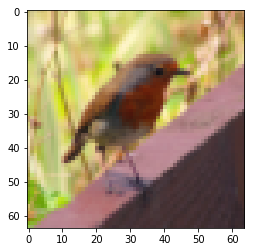

In [157]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [158]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [159]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


cost after iteration 0: 0.693050
cost after iteration 100: 0.646432
cost after iteration 200: 0.632514
cost after iteration 300: 0.601502
cost after iteration 400: 0.560197
cost after iteration 500: 0.515830
cost after iteration 600: 0.475490
cost after iteration 700: 0.433916
cost after iteration 800: 0.400798
cost after iteration 900: 0.358071
cost after iteration 1000: 0.339428
cost after iteration 1100: 0.305275
cost after iteration 1200: 0.274914
cost after iteration 1300: 0.246818
cost after iteration 1400: 0.198507
cost after iteration 1500: 0.174483
cost after iteration 1600: 0.170808
cost after iteration 1700: 0.113065
cost after iteration 1800: 0.096294
cost after iteration 1900: 0.083426
cost after iteration 2000: 0.074391
cost after iteration 2100: 0.066307
cost after iteration 2200: 0.059193
cost after iteration 2300: 0.053361
cost after iteration 2400: 0.048555
[0.69304973565998895, 0.64643209534288493, 0.6325140647912677, 0.60150249203546646, 0.56019663116057472, 0.51583

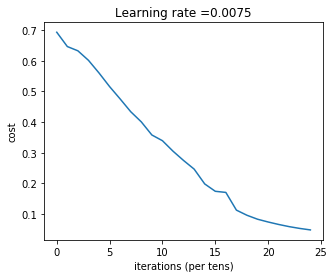

In [178]:
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
dims = [n_x, n_h, n_y]
layer_act = {"L1":"relu", "L2":"sigmoid"}

def deep_nn(X, Y, dims, layer_act, learning_rate, num_iterations = 300):
    para = initialization(dims)
    costs = []
    for i in range(num_iterations):
        comput = foward(X, para, layer_act, dims)
        pred = comput["A" + str(len(dims) - 1)]
        cost_now = cost(pred, Y)
        
        
        diff = backprop(comput, Y, layer_act, dims)
        updated = update(para, diff, learning_rate)
        para = updated
        
        if i % 100 == 0:
            print("cost after iteration %i: %f" %(i, cost_now))
            costs.append(cost_now)
    
    plt.plot(np.squeeze(costs))
    print(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return para
    
parameters = deep_nn(train_x, train_y, dims,layer_act, learning_rate= 0.0075, num_iterations = 2500)


In [ ]:
dims = [12288,5,4,3,2,1]
layer_act = {"L1":"relu","L2":"relu","L3":"relu","L4":"relu","L5":"sigmoid"}
parameters = deep_nn(train_x, train_y, dims,layer_act, learning_rate= 0.0075, num_iterations = 2500)

